In [62]:
!which python

/home/hienpth/miniconda3/envs/p4ds-env/bin/python


# Final project: Phân tích dữ liệu Data Engineer Jobs
Các thành viên:

1. Phạm Thị Hoài Hiền - 18120178

2. Vương Thị Ngọc Linh - 18120195

In [63]:
import numpy as np 
import matplotlib as plt
import pandas as pd
import re

## Giới thiệu về dữ liệu

Đây là bộ dữ liệu về việc làm Data Engineer và một số vị trí liên quan, link Kaggle lấy dữ liệu: https://www.kaggle.com/andrewmvd/data-engineer-jobs

Datatset này được tạo bởi Picklesueat và nó chứa hơn 2500 công việc liên quan vị trí Data Engineer.

Dataset gồm có 15 cột:
- Job Tile: Tên vị trí
- Salary Estimate: Mức lương
- Job Description: Miêu tả vị trí
- Rating: Xếp hạng công ty tuyển dụng
- Company name: Tên công ty tuyển dụng
- Location: Địa chỉ nơi làm việc
- Headquarters: Trụ sở của công ty
- Size: Quy mô nhân lực của công ty
- Founded: Năm thành lập công ty
- Type of ownership: Quyền sở hữu
- Industry: Lĩnh vực hoạt động của công ty
- Sector: Lĩnh vực chuyên ngành mà công ty phát triển.
- Revenue: Doanh thu mỗi năm của công ty.
- Competitors: Đối thủ cạnh tranh của công ty.
- Easy Apply: Vị trí này có dễ apply không.


## Tiền xử lí

### Đọc dữ liệu vào dataframe

In [64]:
data_engineer_jobs = pd.read_csv("DataEngineer.csv")
data_engineer_jobs.shape

(2528, 15)

Dataset có 2528 dòng và 15 cột, đúng như miêu tả.

In [65]:
data_engineer_jobs.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,Data Engineer,$80K-$150K (Glassdoor est.),Company Description\nSagence is a management a...,4.5,Sagence\n4.5,"New York, NY","Chicago, IL",1 to 50 employees,2009,Company - Private,Consulting,Business Services,$10 to $25 million (USD),"WCI Consulting, PwC",-1
1,Senior Data Engineer (Healthcare Domain experi...,$80K-$150K (Glassdoor est.),"Key Responsibilities\n\n- Architect, build, an...",3.4,Enterprise Integration\n3.4,"New York, NY","Jacksonville, FL",51 to 200 employees,1998,Company - Private,IT Services,Information Technology,$25 to $50 million (USD),-1,-1
2,Data Engineers,$80K-$150K (Glassdoor est.),Overview\n\nJob description\n\nPosition Overvi...,5.0,Maestro Technologies\n5.0,"New York, NY","Trenton, NJ",51 to 200 employees,2003,Company - Private,IT Services,Information Technology,$5 to $10 million (USD),-1,-1
3,Client Trade Support Engineer,$80K-$150K (Glassdoor est.),About the Position\n\n\nThis position will sup...,4.8,Jane Street\n4.8,"New York, NY","New York, NY",501 to 1000 employees,2000,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,-1,-1
4,Data Engineer,$80K-$150K (Glassdoor est.),Data Engineer\n\nJob Details\nLevel\nExperienc...,3.7,GNY Insurance Companies\n3.7,"New York, NY","New York, NY",201 to 500 employees,1914,Company - Private,Insurance Carriers,Insurance,$100 to $500 million (USD),"Travelers, Chubb, Crum & Forster",True


### Xử lí các cột numeric

In [66]:
data_engineer_jobs.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply'],
      dtype='object')

Có đầy đủ các cột và nó có tên đúng như mô tả. Tiếp theo ta sẽ xem kiểu dữ liệu của cột.

In [67]:
data_engineer_jobs.dtypes

Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
Easy Apply            object
dtype: object

Theo lí thuyết ta sẽ phải có những cột này là kiểu numeric: `Salary Estimate`, `Rating`, `Founded`, `Size`, `Revenue`. Tuy nhiên theo kết quả trên thì các cột `Salary Estimate`, `Size` và `Revenue` chưa có đúng kiểu dữ liệu (object thay vì int hoặc float). Ta tiến hành đổi kiểu dữ liệu lại cho 3 cột này.

**Đổi kiểu dữ liệu cột `Salary Estimate`**

In [68]:
data_engineer_jobs["Salary Estimate"].unique()

array(['$80K-$150K (Glassdoor est.)', '$73K-$94K (Glassdoor est.)',
       '$85K-$154K (Glassdoor est.)', '$84K-$113K (Glassdoor est.)',
       '$57K-$75K (Glassdoor est.)', '$105K-$121K (Glassdoor est.)',
       '$92K-$117K (Glassdoor est.)', '$88K-$136K (Glassdoor est.)',
       '$95K-$167K (Glassdoor est.)', '$79K-$146K (Glassdoor est.)',
       '$93K-$106K (Glassdoor est.)', '$115K-$201K (Glassdoor est.)',
       '$94K-$164K (Glassdoor est.)', '$49K-$98K (Glassdoor est.)',
       '$56K-$108K (Glassdoor est.)', '$85K-$158K (Glassdoor est.)',
       '$133K-$210K (Glassdoor est.)', '$95K-$99K (Glassdoor est.)',
       '$67K-$72K (Glassdoor est.)', '$53K-$100K (Glassdoor est.)',
       '$81K-$100K (Glassdoor est.)', '$94K-$107K (Glassdoor est.)',
       '$43K-$84K (Glassdoor est.)', '$62K-$92K (Glassdoor est.)',
       '$55K-$106K (Glassdoor est.)', '$69K-$103K (Glassdoor est.)',
       '$54K-$113K (Glassdoor est.)', '$74K-$123K (Glassdoor est.)',
       '$69K-$122K (Glassdoor est.)', 

Tất cả các giá trị đều được biểu diễn trong một khoảng cố định. `Glassdoor est.` là mức lương ước tính trên trang việc làm trực tuyến `Glassdoor`. 
Ta đổi giá trị của cột `Salary Estimate` từ mức lương min-max thành mức lương trung bình để dễ dàng so sánh và tính toán.
Rất may là cột này không có giá trị thiếu.

In [69]:
def find_mean_salary(x):
    S = [int(s) for s in re.findall(r'\d+', x)] #liệt kê (list) tất cả số nguyên trong x
    return (S[0] + S[1]) / 2

data_engineer_jobs["Salary Estimate"] = data_engineer_jobs["Salary Estimate"].apply(find_mean_salary)
data_engineer_jobs = data_engineer_jobs.rename(columns={"Salary Estimate": "Salary est. (thousand USD)"})

**Đổi kiểu dữ liệu cột `Size`**

In [70]:
data_engineer_jobs['Size'].unique()

array(['1 to 50 employees', '51 to 200 employees',
       '501 to 1000 employees', '201 to 500 employees',
       '1001 to 5000 employees', '10000+ employees',
       '5001 to 10000 employees', 'Unknown', '-1'], dtype=object)

Ta thấy chỉ có 7 giá trị phân biệt và 2 giá trị missing (unknown, -1). 
Vậy ta quy đổi thành các giá trị từ 1-7 thể hiện cho quy mô tăng dần như sau:
- Mức độ 1: 1 to 50 employees
- Mức độ 2: 51 to 200 employees
- Mức độ 3: 201 to 500 employees
- Mức độ 4: 501 to 1000 employees
- Mức độ 5: 1001 to 5000 employees
- Mức độ 6: 5001 to 10000 employees
- Mức độ 7: 10000+ employees
Các giá trị -1 và unknown ta sẽ để bằng 0.

In [71]:
def transform_size(x):
    if x == '1 to 50 employees':
        return 1
    elif x == '51 to 200 employees':
        return 2
    elif x == '201 to 500 employees':
        return 2
    elif x == '501 to 1000 employees':
        return 4
    elif x == '1001 to 5000 employees':
        return 5
    elif x == '5001 to 10000 employees':
        return 6
    elif x == '10000+ employees':
        return 7
    else:
        return -1

data_engineer_jobs['Size'] = data_engineer_jobs['Size'].apply(transform_size)

**Đổi kiểu dữ liệu cột `Revenue`**

In [72]:
data_engineer_jobs['Revenue'].unique()

array(['$10 to $25 million (USD)', '$25 to $50 million (USD)',
       '$5 to $10 million (USD)', 'Unknown / Non-Applicable',
       '$100 to $500 million (USD)', '$2 to $5 billion (USD)',
       '$500 million to $1 billion (USD)', '$50 to $100 million (USD)',
       '$10+ billion (USD)', '$1 to $2 billion (USD)',
       '$1 to $5 million (USD)', 'Less than $1 million (USD)',
       '$5 to $10 billion (USD)', '-1'], dtype=object)

Ta thấy có rất nhiều cách biểu diễn khác nhau cho cột này (có khoảng from..to, có con số X+, có less than). 
Do số tiền chỉ có đơn vị là triệu (million) và tỷ (billion) nên ta sẽ đổi hết giá trị về thành đơn vị tỉ đô
Đổi giá trị cột `Revenue` từ các khoảng doanh thu bằng `giá trị cao nhất (max)` trong khoảng:
- Các dòng có giá trị X+ sẽ được quy ước là X+1
- Các dòng có giá trị Less than X quy ước là X 
- Missing value sẽ được quy ước là 0

In [73]:
def find_max_revenue(x):
    if x == 'Unknown / Non-Applicable' or x == '-1':
        return -1
    else:
        S = [int(s) for s in re.findall(r'\d+', x)]
        if 'billion' in x and 'million' not in x:
            S = [s*1000 for s in S]
        if '+' in x:
            S.append(S[0] + 1)
        if 'Less than' in x:
            S.append(S[0])
            S[0] = 0
        return S[1]
data_engineer_jobs['Revenue'] = data_engineer_jobs['Revenue'].apply(find_max_revenue)
data_engineer_jobs = data_engineer_jobs.rename(columns={'Revenue': 'Revenue (million USD)'})

### Xử lí các cột category

Ở cột `Company Name`, ta thấy có phần "\n rating" phía sau tên công ty là dư thừa (vì đã có cột `rating` riêng), vì vậy ta xoá nó đi.

In [74]:
data_engineer_jobs['Company Name'] = data_engineer_jobs['Company Name'].str.partition("\n")

Ta xem xét một vài thống kê trong các cột category:

In [75]:
data_engineer_jobs.describe(include=[object])  

,Job Title,Job Description,Company Name,Location,Headquarters,Type of ownership,Industry,Sector,Competitors,Easy Apply
count,2528,2528,2528,2528,2528,2528,2528,2528,2528,2528
unique,1260,2296,1451,113,436,14,84,25,331,2
top,Data Engineer,Organization: Accenture Federal Services\n\nLo...,Amazon,"Austin, TX","New York, NY",Company - Private,-1,Information Technology,-1,-1
freq,469,7,28,199,178,1392,378,890,1749,2382


Ta chú ý cột `Company Name` chỉ có 1451 giá trị phân biệt, vậy có thể suy ra là một công ty có tuyển nhiều vị trí hoặc công ty có nhiều chi nhánh ở các nơi khác nhau nên mới có sự trùng lặp về tên công ty. Ta sẽ sử dụng ý này để xử lí missing value ở phần sau.

### Xử lí missing value

In [76]:
data_engineer_jobs.isnull().sum() / len(data_engineer_jobs) * 100

Job Title                     0.0
Salary est. (thousand USD)    0.0
Job Description               0.0
Rating                        0.0
Company Name                  0.0
Location                      0.0
Headquarters                  0.0
Size                          0.0
Founded                       0.0
Type of ownership             0.0
Industry                      0.0
Sector                        0.0
Revenue (million USD)         0.0
Competitors                   0.0
Easy Apply                    0.0
dtype: float64

Tỉ lệ missing value của tưng cột là 0.0, tuy nhiên sau khi xem dữ liệu, có thể thấy tác giả đã thay các giá trị thiếu thành `-1` và `Unknown / Non-Applicable`.
Phần `Unknown / Non-Applicable` ta đã xử lí ở cột `Revenue` rồi nên bây giờ chỉ xem xét tới giá trị -1 ở các cột.

In [77]:
def find_missing_value(col):
    if col.dtypes == np.dtype('int64') or col.dtypes == np.dtype('float64'):
        return abs(col[col == -1].sum() / len(col) * 100)
    else:
        return len(col[col == '-1']) / len(col) * 100
missing_ratio = data_engineer_jobs.apply(find_missing_value)
missing_ratio

Job Title                      0.000000
Salary est. (thousand USD)     0.000000
Job Description                0.000000
Rating                         9.256329
Company Name                   0.000000
Location                       0.000000
Headquarters                   4.905063
Size                           7.199367
Founded                       22.587025
Type of ownership              4.707278
Industry                      14.952532
Sector                        14.833861
Revenue (million USD)         32.950949
Competitors                   69.185127
Easy Apply                    94.224684
dtype: float64

Cột Competitors và Easy Apply có rất nhiều missing value, và dữ liệu hai cột này cũng không cần thiết cho câu hỏi, vì vậy sẽ xóa hai cột này để làm sạch dữ liệu.

In [78]:
data_engineer_jobs = data_engineer_jobs.drop(columns=['Competitors', 'Easy Apply'])

Đối với các cột có tỉ lệ missing cao (`Industry`, `Sector`, `Revenue`, `Founded`), ta sẽ xử lí nó theo từng câu hỏi đặt ra ở phần sau.

In [79]:
data_engineer_jobs[data_engineer_jobs['Industry'] == '-1']

,Job Title,Salary est. (thousand USD),Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue (million USD)
15,Data Engineer,115.0,Job Description\n\nData Engineer\n\nAt Citadel...,3.8,Citadel,"New York, NY","Chicago, IL",5,1990,Company - Private,-1,-1,100
17,Service Engineer / Appliance Tech (Bi-lingual ...,115.0,Company Profile\n\nCEF Solutions Inc. is a Con...,3.0,CEF Solutions Inc.,"Hackensack, NJ","Fort Lee, NJ",1,-1,Company - Public,-1,-1,-1
41,Data Engineer,83.5,Data profiling - Create physical Database desi...,-1.0,Aptino,"New York, NY","Irving, TX",2,-1,Company - Private,-1,-1,-1
54,Data Engineer,83.5,"At Clear Street, we are disrupting the institu...",-1.0,Clear Street,"New York, NY","New York, NY",2,2018,Company - Public,-1,-1,5
56,Data Engineer,83.5,Job Description\nData Engineer\nNew York (Head...,1.0,Tiro,"New York, NY","Minneapolis, MN",2,-1,Company - Private,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,Senior Data Engineer - Informatica,61.0,Your Opportunity\n\nDo you want to be part of ...,3.5,Schwab,"Westlake, TX","Dettenheim, Germany",-1,-1,Company - Public,-1,-1,-1
2481,Wiring Installation Engineer,72.5,Wiring Installation Engineer\n\nLocation: Fort...,3.8,Butler Technical Group,"Fort Worth, TX","Kanpur Nagar, India",4,-1,College / University,-1,-1,-1
2495,Full Stack Software Engineer,72.5,We are pioneers. We were the first to break th...,-1.0,Cessna,"Fort Worth, TX","Arvada, CO",1,-1,Company - Private,-1,-1,-1
2504,Senior Big Data Engineer,72.5,"Your Opportunity\n\nAt Schwab, the Global Data...",3.5,Schwab,"Westlake, TX","Dettenheim, Germany",-1,-1,Company - Public,-1,-1,-1


**Xử lí missing value cột `Industry` và `Sector`**

Như đã đề cập ở trên, tên công ty bị trùng khá nhiều, ta có thể dùng tên công ty để giảm bớt missing value của hai cột `Industry` và `Sector` (bởi vì cùng công ty thì sẽ có Industry và Sector giống nhau, giả sử không có hai công ty khác nhau nào bị trùng tên).

Ta tiến hành tìm những dòng có cùng tên công ty và tiến hành điền giá trị ở hai cột `Industry` và `Sector` nếu nó bị thiếu.

In [80]:
##Code HERE

**Xử lí missing value của cột `Revenue`**

In [81]:
company = data_engineer_jobs[data_engineer_jobs['Revenue (million USD)'] == -1]
company = company.groupby(['Company Name']).size()
company = company[company > 1].to_frame(name = 'Missing_size')
company

,Missing_size
Company Name,
ARC Group,2
"AbleForce, Inc.",2
Aerotek,2
Affinity Solutions,3
Akuna Capital,2
...,...
"foresee medical, inc.",2
iSphere,2
ingenium.agency,2


In [82]:
company = company.reset_index(level=0)
company.columns

Index(['Company Name', 'Missing_size'], dtype='object')

In [83]:
tmp = data_engineer_jobs[['Company Name', 'Location', 'Sector', 'Revenue (million USD)']]
tmp.columns

Index(['Company Name', 'Location', 'Sector', 'Revenue (million USD)'], dtype='object')

In [84]:
tmp = tmp.merge(company, left_on='Company Name', right_on='Company Name')
tmp

,Company Name,Location,Sector,Revenue (million USD),Missing_size
0,Jane Street,"New York, NY",Finance,-1,3
1,Jane Street,"New York, NY",Finance,-1,3
2,Jane Street,"New York, NY",Finance,-1,3
3,Affinity Solutions,"New York, NY",Business Services,-1,3
4,Affinity Solutions,"New York, NY",Business Services,-1,3
...,...,...,...,...,...
383,"Avacend, Inc.","Southlake, TX",Business Services,-1,2
384,Citibank,"Irving, TX",Finance,-1,2
385,Citibank,"Irving, TX",Finance,-1,2
386,Fidelity TalentSource,"Westlake, TX",Business Services,-1,2


In [85]:
name_of_lost_company = tmp[tmp['Revenue (million USD)']>0]['Company Name']
name_of_lost_company = name_of_lost_company.unique()
tmp[tmp['Company Name'].isin(list(name_of_lost_company))]


,Company Name,Location,Sector,Revenue (million USD),Missing_size
26,ingenium.agency,"New York, NY",Business Services,5,2
27,ingenium.agency,"New York, NY",Business Services,5,2
28,ingenium.agency,"New York, NY",-1,-1,2
29,ingenium.agency,"Los Angeles, CA",Business Services,5,2
30,ingenium.agency,"Los Angeles, CA",-1,-1,2
309,pddninc.net,"Dallas, TX",Consumer Services,1,3
310,pddninc.net,"Dallas, TX",-1,-1,3
311,pddninc.net,"Sunnyvale, CA",Consumer Services,1,3
312,pddninc.net,"Sunnyvale, CA",-1,-1,3
313,pddninc.net,"Austin, TX",Consumer Services,1,3


### Xử lí cột `Job Title`

Ở đây ta quan tâm đến 2 job là Data Engineer và Senior Data Engineer, và có rất nhiều job thuộc 2 loại này nhưng có title khác nhau, ví dụ: Big Data Engineer, Data Engineer II,... Vì vậy cần đồng bộ các title này trở về 2 loại chính. Đầu tiên là sửa lại title chứa Sr. thành Senior để dễ xử lý.

In [86]:
data_engineer_jobs['Job Title'] = data_engineer_jobs['Job Title'].str.replace('Sr.','Senior', regex=True)

Tiếp theo ta thay đổi tất cả title chứa cụm 'Data Engineer' -> Data Engineer và tương tự với Senior Data Engineer và lưu lại vào cột Job Title.

In [87]:
title = []
job_title = data_engineer_jobs['Job Title'].values
for each in job_title:
    if 'Senior Data Engineer' not in each:
        #lệnh re replace các title Data Engineer
        x = re.sub("[\w\s\S]*Data[\w\s\S]*Engineer[\w\s\S]*",'Data Engineer',each,flags=re.IGNORECASE) 
    else:
        #lệnh re thay đổi các title Senior Data Engineer
        x = re.sub("[\w\s\S]*Senior[\w\s\S]*Data[\w\s\S]*Engineer[\w\s\S]*",'Senior Data Engineer', each,flags=re.IGNORECASE)
    title.append(x)

In [88]:
data_engineer_jobs['Job Title']= title
data_engineer_jobs['Job Title'].value_counts()

Data Engineer                                  1275
Senior Data Engineer                            160
Software Engineer                                93
Machine Learning Engineer                        17
Systems Engineer                                 13
                                               ... 
Software Engineer/Data Analyst                    1
Senior Validation and Verification Engineer       1
Electrical Instrumentation Engineer               1
Senior Thermal Modeling Engineer                  1
COMPUTER ENGINEER                                 1
Name: Job Title, Length: 759, dtype: int64

## Các câu hỏi cần trả lời


### 1- Mức lương trung bình của từng job là bao nhiêu? Mức lương cho Senior data là bao nhiêu?

In [89]:
temp = data_engineer_jobs[["Job Title","Salary est. (thousand USD)"]].groupby(["Job Title"]).sum().sort_values(by=['Salary est. (thousand USD)'], ascending=False)
temp["Salary est. (thousand USD)"] = temp["Salary est. (thousand USD)"] / data_engineer_jobs["Job Title"].value_counts()
temp

,Salary est. (thousand USD)
Job Title,
Data Engineer,104.540784
Senior Data Engineer,106.593750
Software Engineer,107.553763
Machine Learning Engineer,95.235294
Systems Engineer,94.423077
...,...
Principal Systems Engineer,38.500000
Equipment Engineer,38.500000
Engineer Quality Control Inspector with Security Clearance,38.500000


<AxesSubplot:xlabel='Job Title'>

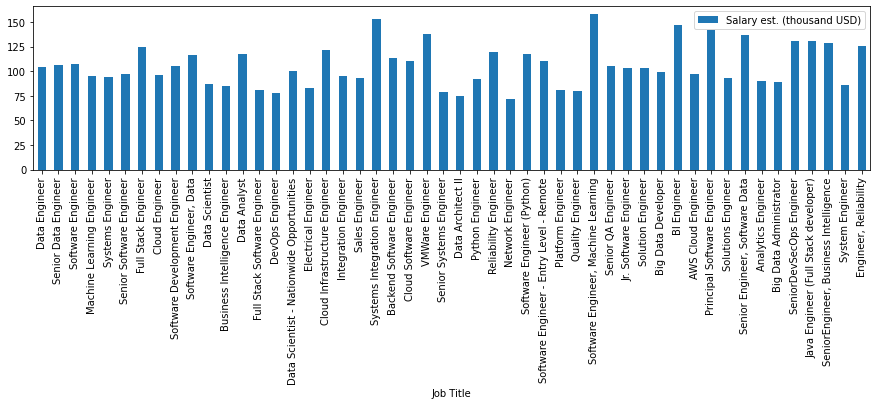

In [90]:
temp.head(50).plot.bar(figsize=(15,3))

Vì có đến hơn 700 job khác nhau nên chỉ show mức lương trung bình của top 50 job đầu (cũng là 50 job được tuyển nhiều nhất).

In [91]:
temp[temp.index == "Senior Data Engineer"].values

array([[106.59375]])

Như vậy, Senior Data Engineer có mức lương trung bình là 106 triệu USD.

### 2 - Top 5 lĩnh vực tuyển dụng data engineer (tất cả các vị trí) nhiều nhất?

<AxesSubplot:>

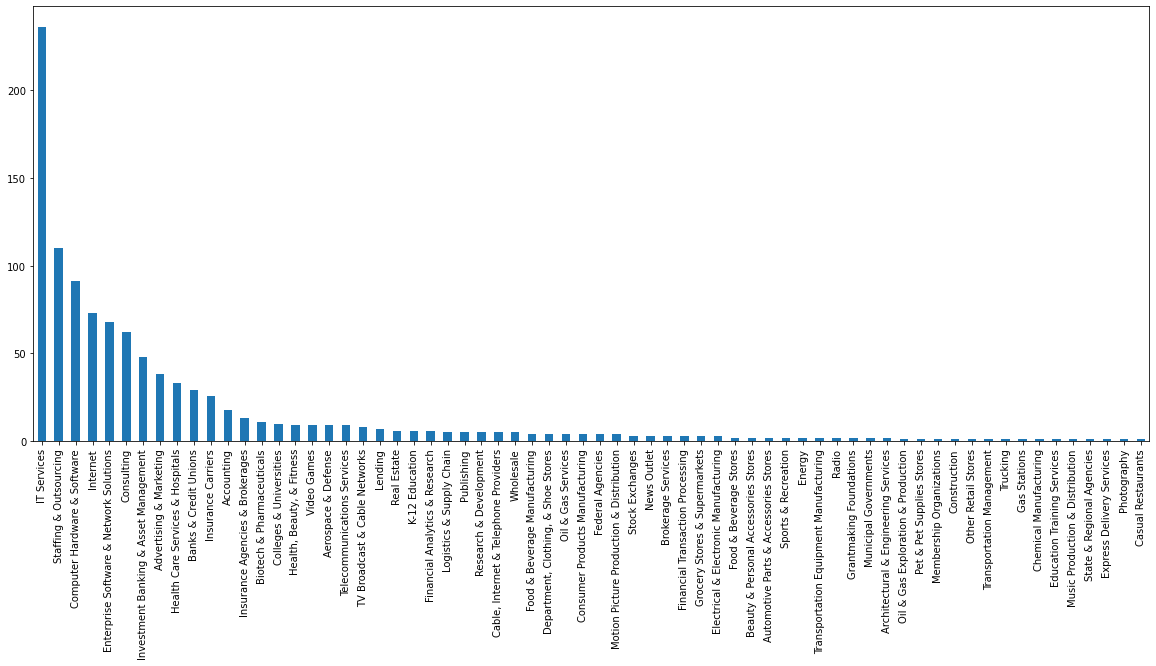

In [119]:
industry = data_engineer_jobs[data_engineer_jobs['Job Title'] == "Data Engineer"]["Industry"].value_counts()
industry.drop(labels=['-1']).plot.bar(figsize=(20,8))

**5 lĩnh vực tuyển dụng data engineer nhiều nhất là:**

In [93]:
industry.drop(labels=['-1']).head(5)

IT Services                                236
Staffing & Outsourcing                     110
Computer Hardware & Software                91
Internet                                    73
Enterprise Software & Network Solutions     68
Name: Industry, dtype: int64

### 3 - Top 10 location tuyển dụng nhiều vị trí nhất?

In [97]:
#Code
location = data_engineer_jobs['Location'].value_counts()
location.head(10)

Austin, TX          199
Houston, TX         199
San Diego, CA       195
Chicago, IL         192
San Antonio, TX     190
New York, NY        187
Philadelphia, PA    135
Jacksonville, FL    122
Phoenix, AZ         117
Los Angeles, CA     106
Name: Location, dtype: int64

### 4 - Lĩnh vực nào có mức lương trung bình (trên tất cả job) cao nhất và thấp nhất?

In [95]:
#Code

### 5 - Các skill cần thiết của từng job là gì?

In [175]:
pg_req = ["python", "c++", "java", "matlab", ".net", "c#", "javascript", "html", "bash"]
pg_lan = np.zeros(len(pg_req))

In [176]:
def count_pg_lan(language):
    if language == 'c++':
        language = 'c\+\+'
    elif language == '.net':
        language = '\.net'
    elif language == 'c#':
        language = 'c\#'
    tmp = data_engineer_jobs['Job Description'].str.lower()
    return tmp.str.count(language, flags=re.IGNORECASE).sum()

for req in pg_req:
    pg_lan[pg_req.index(req)] = count_pg_lan(req)

pg_lan_df = pd.DataFrame([pg_req, pg_lan]).T
pg_lan_df = pg_lan_df.rename(columns={0: 'Programming Language', 1: 'Count'})
pg_lan_df.sort_values(['Count'], axis=0, ascending=False, inplace=True)
pg_lan_df.set_index('Programming Language', inplace=True)
pg_lan_df



,Count
Programming Language,
python,2058.0
java,1522.0
javascript,318.0
c++,313.0
.net,195.0
c#,174.0
html,154.0
bash,129.0
matlab,58.0


<AxesSubplot:xlabel='Programming Language'>

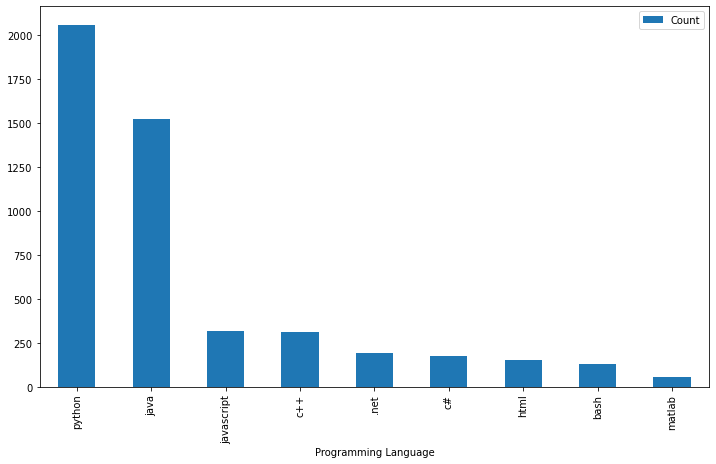

In [177]:
pg_lan_df.plot.bar(figsize=(12,7))

In [183]:
ds_ml_req = ["machine learning","regression","stat","numpy","pandas","data visualization","data analysis","time series","data cleaning","deep learning"]
ds_ml_count = np.zeros(len(ds_ml_req))
def count_skills_ds_ml(skill):
    tmp = data_engineer_jobs['Job Description'].str.lower()
    if skill == 'machine learning':
        return tmp.str.count(skill, flags=re.IGNORECASE).sum() + tmp.str.count(' ml ', flags=re.IGNORECASE).sum()
    elif skill == 'deep learning':
        return tmp.str.count(skill, flags=re.IGNORECASE).sum() + tmp.str.count(' dl ', flags=re.IGNORECASE).sum()
    return tmp.str.count(skill, flags=re.IGNORECASE).sum()

for req in ds_ml_req:
    ds_ml_count[ds_ml_req.index(req)] = count_skills_ds_ml(req)

ds_ml_df = pd.DataFrame([ds_ml_req, ds_ml_count]).T
ds_ml_df = ds_ml_df.rename(columns={0: 'DS/ML skill', 1: 'Count'})
ds_ml_df.sort_values(['Count'], axis=0, ascending=False, inplace=True)
ds_ml_df.set_index('DS/ML skill', inplace=True)
ds_ml_df

,Count
DS/ML skill,
stat,3574.0
machine learning,1043.0
data analysis,310.0
data visualization,203.0
deep learning,116.0
regression,86.0
pandas,58.0
numpy,41.0
data cleaning,15.0


<AxesSubplot:xlabel='DS/ML skill'>

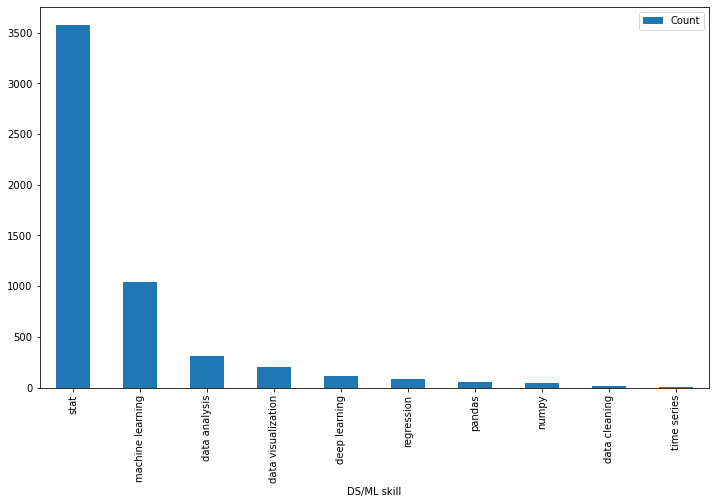

In [184]:
ds_ml_df.plot.bar(figsize=(12,7))

In [192]:
edu_req = ["master","doctorate","bachelor"]
edu_count = np.zeros(len(edu_req))
def count_edu(degree):
    tmp = data_engineer_jobs['Job Description'].str.lower()
    if degree == 'master':
        return tmp.str.count(degree, flags=re.IGNORECASE).sum() + tmp.str.count(' ms ', flags=re.IGNORECASE).sum()
    elif degree == 'bachelor':
        return tmp.str.count(degree, flags=re.IGNORECASE).sum() + tmp.str.count(' bs ', flags=re.IGNORECASE).sum()
    else:
        return tmp.str.count(degree, flags=re.IGNORECASE).sum() + tmp.str.count(' phd ', flags=re.IGNORECASE).sum()

for req in edu_req:
    edu_count[edu_req.index(req)] = count_edu(req)

edu_df = pd.DataFrame([edu_req, edu_count]).T
edu_df = edu_df.rename(columns={0: 'Education', 1: 'Count'})
edu_df.sort_values(['Count'], axis=0, ascending=False, inplace=True)
edu_df.set_index('Education', inplace=True)
edu_df

,Count
Education,
bachelor,1213.0
master,776.0
doctorate,84.0


<AxesSubplot:xlabel='Education'>

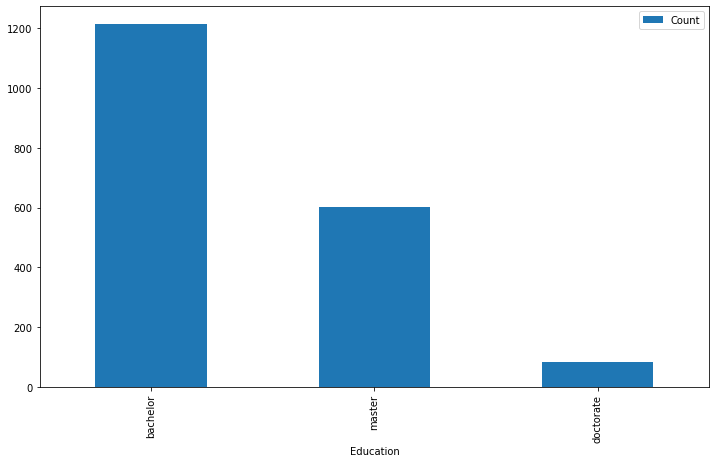

In [191]:
edu_df.plot.bar(figsize=(12,7))